input : 5 * 128 * 128 * 1

In [1]:
import dicom
import inspect
import pylab
import numpy as np
from glob import glob
import os

import matplotlib
import matplotlib.pyplot as plt

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from utils.data_manager import load_patient, normalize, Patient, data_generator
from model.shifting_sandwich import shifting_sandwich_model

from scipy import ndimage

import math
from sys import stdout

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
baseDir = 'shifting_sandwich'

In [3]:
benign = glob('slimdata/benign*')
malign = glob('slimdata/malign*')
np.random.shuffle(benign)
np.random.shuffle(malign)

b_train = benign[:62]
m_train = malign[:220]

b_valid = benign[62:]
m_valid = malign[220:]

benign_gen = data_generator(b_train, nodule_ratio=0.7, hand_size=4, turnover=1)
malign_gen = data_generator(m_train, nodule_ratio=0.7, hand_size=4, turnover=1)
bv_gen = data_generator(b_valid, nodule_ratio=0.7, hand_size=2, turnover=0)
mv_gen = data_generator(m_valid, nodule_ratio=0.7, hand_size=2, turnover=0)

In [4]:
def gen_combinator(genList):
    while True:
        xx = []
        yy = []
        for gen in genList:
            X, y = next(gen)
            xx.append(X)
            yy.append(y)
        yield np.vstack(xx), np.hstack(yy)

In [5]:
train_gen = gen_combinator([benign_gen, malign_gen])
valid_gen = gen_combinator([bv_gen, mv_gen])

In [6]:
def print_validation_loss(model):
    mean_loss = np.zeros(3)
    while True:
        X, y = next(valid_gen)
        loss = model.evaluate([X[:,0,:,:], X[:,1,:,:], X[:,2,:,:]], to_categorical(y, nb_classes=3))
        mean_loss = (mean_loss * 0.9) + (np.array(loss) * 0.1)
        print ('validation loss: %f\t prec: %f\trecall: %f' % tuple(mean_loss))
        yield

In [7]:
EPOCH = 30
BATCH = 20

hFile = os.path.join(baseDir,'history.npy')
history = None
if os.path.exists(hFile):
    history = list(np.load(hFile))
else:
    history = []

model = None
if len(history) == 0:
    model = shifting_sandwich_model()
else:
    model = load_model( baseDir + ('model%04d' % (len(history)-1)) )
    
validate = print_validation_loss(model)

In [8]:
for e in range(EPOCH):
    print ('Epoch %d' % e)
    mean_loss = np.array([0, 0, 0])
    for i in range(BATCH):
        X, y = next(train_gen)
        loss = np.array(model.train_on_batch([X[:,0,:,:], X[:,1,:,:], X[:,2,:,:]], to_categorical(y, nb_classes=3)))
        mean_loss = mean_loss + loss
        stdout.write('\rbatch - %d ## train loss: %f\t prec: %f\t recall: %f' % tuple([i] + list(mean_loss / (i + 1))))
    print("")
    next(validate)

Epoch 0
batch - 12 ## train loss: 5.024240	 prec: 0.025641	 recall: 0.057692

KeyboardInterrupt: 

1. 양성 92명 악성 347명 중 일정 비율을 뽑는다.
b_train, m_train, b_valid, m_valid

2. 각 환자를 각 generator 에 넣고, validation 은 완전 랜덤으로 (한사람만 뽑아서?) 디스크를 읽어서 뽑고, 양성은 turn over 를 정해서 pool을 만들어놓고 그 안에서 매번 뽑는 위치는 완벽히 랜덤으로 돌리자.

3. check_note(오답노트) 는 어느정도 트레이닝이 된 후에 다시 생각해도 그때가서 끼워넣을 수 있다.

4. 한번에 체크되는 y는 1 \* 32 \* 32 512

5. layer \* 16 \* 16 \* 4(nroi, nodule, benign, malign)에다가 


(512, 512)


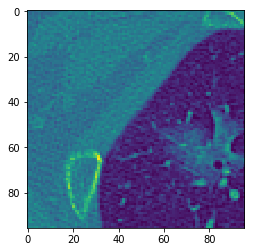

In [42]:
from utils.preprocess import ROI, getRestoreRegionFunction
from skimage import measure

NON_NODULE = 0
NODULE = 1
BENIGN = 2
MALIGN = 3

restore = getRestoreRegionFunction((512,512))

def get_nodule_image(p):
    mask = p['mask']
    image= p['image']
    roi = p['tag'][:,:,:,ROI]
    num_slice = roi.shape[0]

    while True:
        n = np.random.randint(1, num_slice-1)
        regions = measure.regionprops(measure.label(mask[n]))
        if len(regions) == 0 or regions[0].area == 54:
            pass
        else:
            region = regions[0]
            centroid = region.centroid
            x, y = int(centroid[0]), int(centroid[1])
            xdev, ydev = np.random.randint(64, size=2) - 32
            print(image[n].shape)
            plt.imshow(image[n][x+xdev-48:x+xdev+48, y+ydev-48:y+ydev+48])
            plt.show()
            return
        
    scope = np.zeros((512,512))
    scope[32*row-32:32*row+64, 32*col-32:32*col+64] = 1
    
    label = measure.label(mask[n])
    regions = measure.regionprops(label)
    
    ## it's target value to predict
    properties = np.zeros(4)
    
    ## TODO : Add weight on centor of image

    regionStats = []
    
    for region in regions:
        ## exclude large mass of malignant tumor, leaving it's surface
        lesionInRoi = restore(region).astype(bool) & roi[n]
        intersection = np.sum(lesionInRoi & scope)
        ### region.area == 54 : manually filtered data
        if intersection > 0 and region.area != 54:
            properties[BENIGN] = min(1, intersection / max(np.sum(lesionInRoi), 60))
    
        
def get_non_nodule_image(p):
    pass
    
get_nodule_image(p1)